<a href="https://colab.research.google.com/github/iotanalytics/IoTTutorial/blob/main/code/clustering_and_classification/SpectralClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Spectral Clustering [Unsupervised]
*Author: Soumya Pal*

*Updated: Stephen Coshatt*

Spectral clustering is a way to cluster data that has a number of benefits and applications. It relies on the eigenvalue decomposition of a matrix, which is a useful factorization theorem in matrix theory. It is a technique with roots in graph theory, where the approach is used to identify communities of nodes in a graph based on the edges connecting them. The method is flexible and allows us to cluster non graph data as well.

Pros
*   Clusters are not assumed to be any certain shape/distribution, in contrast to say k-means. This means the spectral clustering algorithm can perform well with a wide variety of shapes of data.
*   Works quite well when relations are approximately transitive (like similarity)

Cons
*   Need to choose the number of clusters k, although there is a heuristic to help choose
*   Can be costly to compute, although there are algorithms and frameworks to help
*   For very large datasets computing eigenvectors is computationally expensive and becomes the bottleneck

**References:**


1.   https://www.mygreatlearning.com/blog/introduction-to-spectral-clustering/
2.   https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
3.   https://people.csail.mit.edu/dsontag/courses/ml14/notes/Luxburg07_tutorial_spectral_clustering.pdf




### Types of Similarity Graphs used in Spectral Clustering:


**The ε-neighborhood graph:** Here we connect all points whose pairwise distances are smaller than ε.  As the distances between all connected points are roughly of the same scale (at most ε), weighting the edges would not incorporate more information about the data to the graph. Hence, the ε-neighborhood graph is usually considered as an unweighted graph. [3]

**K-nearest neighbor graphs:** Here the goal is to connect vertex vi with vertex vj if vj is among the k-nearest neighbors of vi. However, this definition leads to a directed graph, as the neighborhood relationship is not symmetric. There are two ways of making this graph undirected. The first way is to simply ignore the directions of the edges, that is we connect vi and vj with an undirected edge if vi is among the k-nearest neighbors of vj or if vj is among the k-nearest neighbors of vi. The resulting graph is what is usually called the k-nearest neighbor graph. The second choice is to connect vertices vi and vj if both vi is among the k-nearest neighbors of vj and vj is among the k-nearest neighbors of vi. The resulting graph is called the mutual k-nearest neighbor graph. In both cases, after connecting the appropriate vertices we weight the edges by the similarity of their endpoints. [3]

**The fully connected graph:** Here we simply connect all points with positive similarity with each other, and we weight all edges by sij . As the graph should represent the local neighborhood relationships, this construction is only useful if the similarity function itself models local neighborhoods. An example for such a similarity function is the Gaussian similarity function s(xi, xj ) = exp(−(xi − xj(2/(2σ2)), where the parameter σ controls the width of the neighborhoods. This parameter plays a similar role as the parameter ε in case of the ε-neighborhood graph. [3]

### Graph Laplacians

The main tools for spectral clustering are graph Laplacian matrices. [3]

The **unnormalized** graph Laplacian L = D – W  [1]

The **normalized** graph Laplacians- There are two matrices which are called normalized graph Laplacians in the literature. Both matrices are closely related to each other and are defined as Lsym := D−1/2LD−1/2 = I − D−1/2W D−1/2
Lrw := D−1L = I − D−1W.  [1]

We denote the first matrix by Lsym as it is a symmetric matrix, and the second one by Lrw as it is closely related to a random walk Eigenvectors and Eigenvalues.  [1]

### Common Spectral Clustering Algorithms [3]:

> Indented block

> Indented block





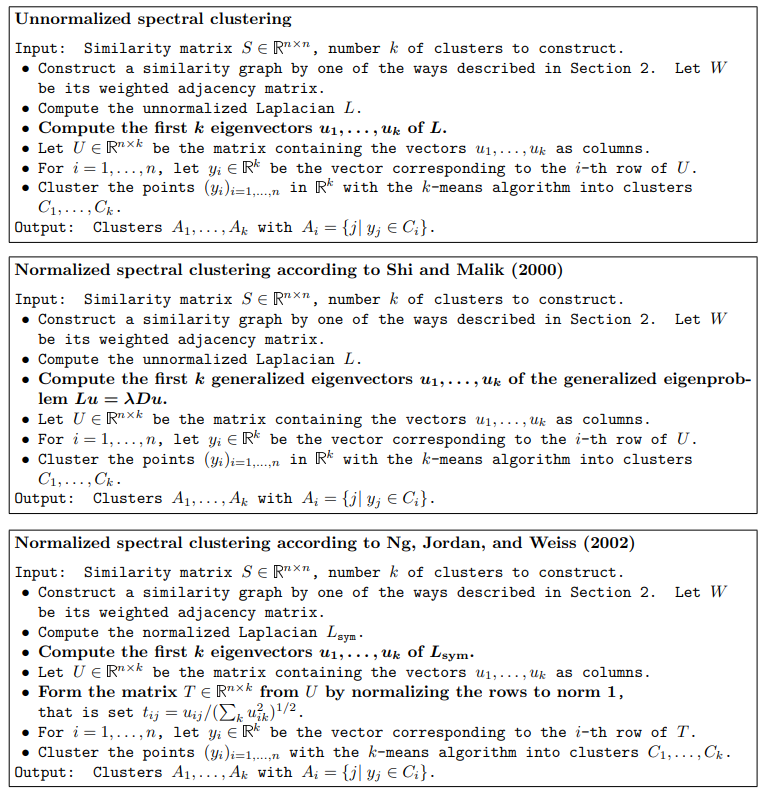

### Graph cut [1]

We wish to partition the graph G(V, E) into two disjoint sets of connected vertices A and B: by simply removing edges connecting two parts.

We define the degree di of a vertex i as the sum of edges weights incident to it: The degree matrix of the graph G denoted by will be a diagonal matrix having the elements on its diagonal and the off-diagonal elements having value 0.

Given two disjoint clusters (subgraphs) A and B of the graph G, we define the following three terms:

*   The sum of weight connections between two clusters:
*   The sum of weight connections within cluster A:
*   The total weights of edges originating from cluster A

In graph theory, there are different objective functions:

*   Minimum cut method
*   Ratio cut method
*   Normalized cut method
*   MinMaxCut cut method

In [1]:
!pip install watermark

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.3
    Uninstalling importlib-metadata-4.6.3:
      Successfully uninstalled importlib-metadata-4.6.3


In [2]:
!pip install influxdb

     |████████████████████████████████| 77 kB 4.2 MB/s 


The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2021-08-17T18:38:25.720497+00:00

Python implementation: CPython
Python version       : 3.7.11
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



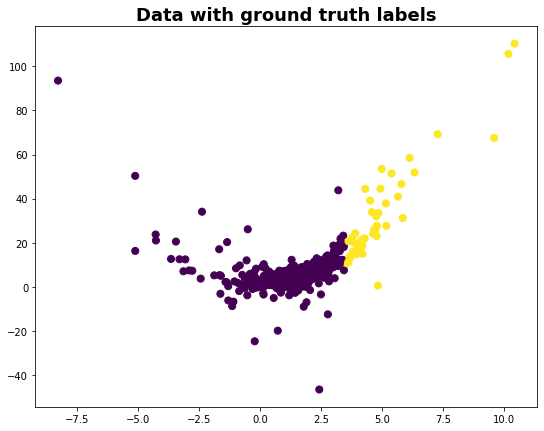

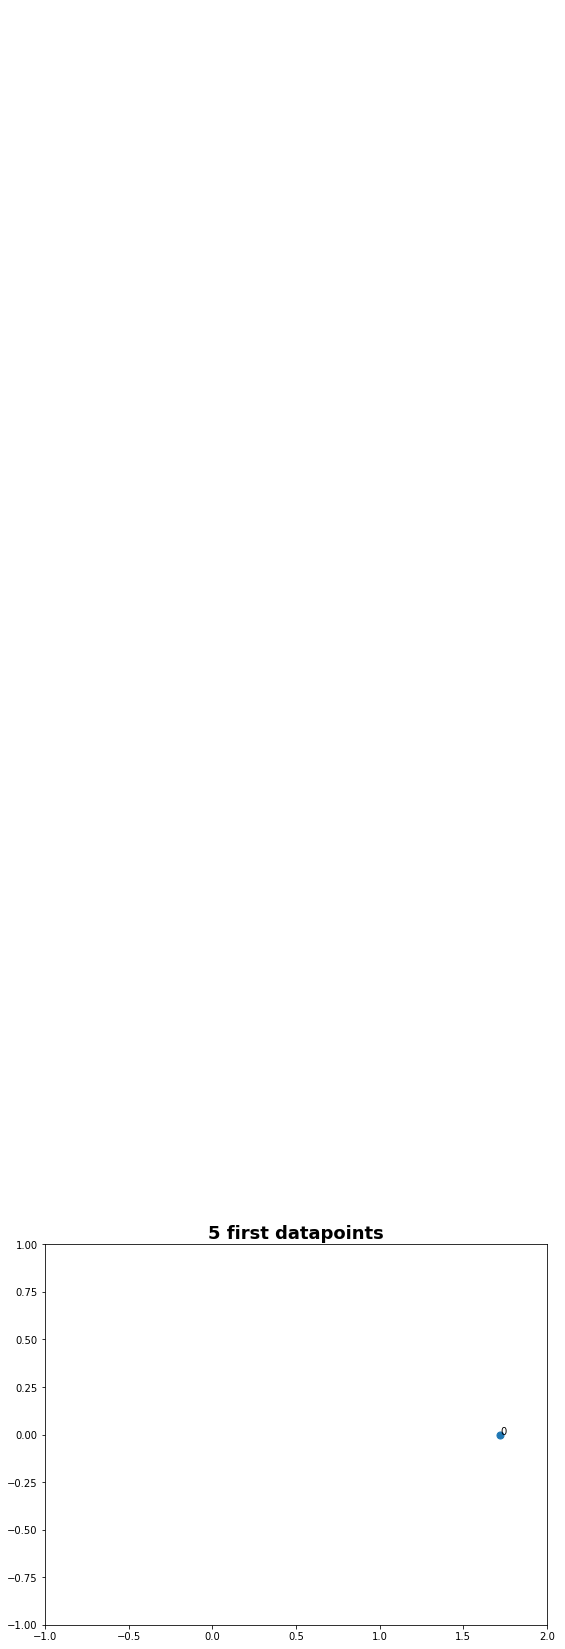

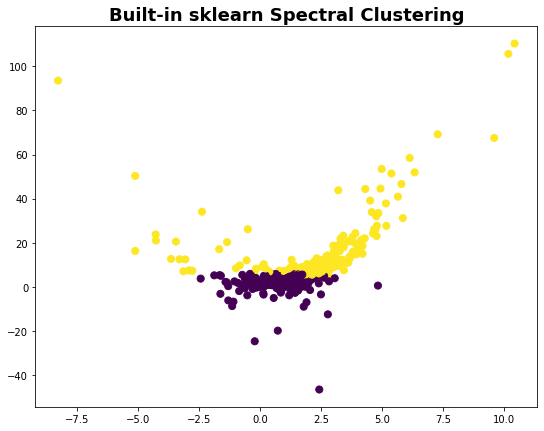

In [5]:
%load_ext watermark
import warnings
warnings.filterwarnings("ignore") 
from IPython.core.display import display, HTML
import time
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.sparse import csgraph
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import radius_neighbors_graph
from sklearn.neighbors import kneighbors_graph
%matplotlib inline
%watermark
from sklearn.datasets import make_moons
from influxdb import InfluxDBClient
import operator

# creating data function
def create_data(type):
  if type=='gen':
    random_state = 21
    X_mn, y_mn = make_moons(150, noise=.07, random_state=random_state)

  elif type=='get':

    client = InfluxDBClient("sensorweb.us", "8086", "test", "sensorweb", "shake", ssl=True)
    unit = "b8:27:eb:16:1b:d7"


    stampIni = "2020-08-14T17:22:15.000Z";
    stampEnd = "2020-08-14T17:25:15.000Z";

    query = 'SELECT "value" FROM Z WHERE ("location" = \''+unit+'\')  and time >= \''+stampIni+'\' and time <= \''+stampEnd+'\'   '

    result = client.query(query)
    points = list(result.get_points())

    values =  map(operator.itemgetter('value'), points)
    times  =  map(operator.itemgetter('time'),  points)

    datat = list(values)
    i=0
    y=[]
    for temp in datat:
      datat[i]=temp/10000
      if temp> 35000.0:
          y.append(1)
      else:
          y.append(0)
      i+=1
    #data= list(times)
    length=8000
    y_mn=y[0:length]
    TEO=[]
    i=0
    while i < length:
        if i>0 and i<length-1:
            temp = datat[i]*datat[i] + datat[i+1]*datat[i-1]
            TEO.append(temp)
        else:
            TEO.append(0)
        i+=1

    X_mn=np.zeros((length,2),dtype=np.float64)
    i=0
    j=0
    while i<length:
        X_mn[i][j]=datat[i]
        X_mn[i][j+1]=TEO[i]
        i+=1
  return X_mn, y_mn
 
#parameters get: for influx streaming seismic data; gen: for generating data
X_mn, y_mn=create_data('get')

cmap = 'viridis'
dot_size=50
fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Data with ground truth labels', fontsize=18, fontweight='demi')
ax.scatter(X_mn[:, 0], X_mn[:, 1],c=y_mn,s=dot_size, cmap=cmap)

A = radius_neighbors_graph(X_mn,0.4,mode='distance', metric='minkowski', p=2, metric_params=None, include_self=False)
A = A.toarray()

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('5 first datapoints', fontsize=18, fontweight='demi')
ax.set_xlim(-1, 2)
ax.set_ylim(-1,1)
ax.scatter(X_mn[:5, 0], X_mn[:5, 1],s=dot_size, cmap=cmap)
for i in range(5):
    ax.annotate(i, (X_mn[i,0],X_mn[i,1]))


model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                          assign_labels='kmeans')
labelsS = model.fit_predict(X_mn)
fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Built-in sklearn Spectral Clustering', fontsize=18, fontweight='demi')

plt.scatter(X_mn[:, 0], X_mn[:, 1], c=labelsS, s=dot_size, cmap=cmap)